라이브러리 불러오기

In [ ]:
!pip install yfinance
!pip install pandas-datareader
!pip install finance-datareader
!pip install pykrx

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import FinanceDataReader as fdr
# import yfinance
# import pykrx
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
def codefind(name):
    krx = fdr.StockListing('KRX')
    search = list(krx['Name'])
    for i in range(len(krx)):
        if (search[i]==name):
            print(krx['Symbol'][i])
            return

In [ ]:
df_ss = pdr.get_data_yahoo('005930.KS','2018-01-01', '2019-12-31')

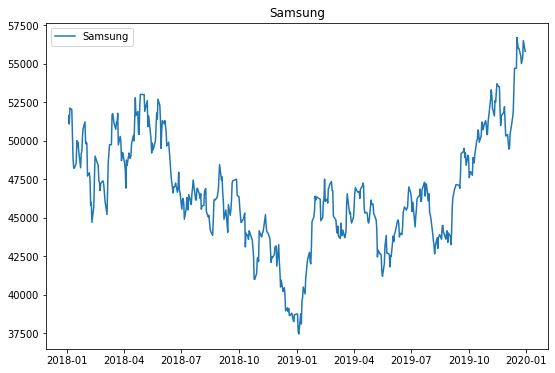

In [ ]:
plt.figure(figsize= (9,6))
plt.title('Samsung')
plt.plot(df_ss.index, df_ss['Close'], label='Samsung')
plt.legend()

일간 변동액& 변동률

In [ ]:
today = df_ss['Close'].shift(1)
last_day= df_ss['Close']

df_ss['price_change'] = today- last_day
df_ss['var_ratio'] = ((today-last_day)/last_day)*100
df_ss.head()

,High,Low,Open,Close,Volume,Adj Close,price_change,var_ratio
Date,,,,,,,,
2018-01-03,52560.0,51420.0,52540.0,51620.0,10013500.0,46235.468750,NaN,NaN
2018-01-04,52180.0,50640.0,52120.0,51080.0,11695450.0,45751.796875,540.0,1.057165
2018-01-05,52120.0,51200.0,51300.0,52120.0,9481150.0,46683.312500,-1040.0,-1.995395
2018-01-08,52520.0,51500.0,52400.0,52020.0,8383650.0,46593.753906,100.0,0.192234
2018-01-09,51720.0,49980.0,51460.0,50400.0,18013600.0,45142.734375,1620.0,3.214286


위의 코드는 pct_change로 표현할 수 있다(단, index가 다름)

In [ ]:
df_ss['Close'].pct_change(periods= -1)*100 

Date
2018-01-03    1.057165
2018-01-04   -1.995395
2018-01-05    0.192234
2018-01-08    3.214286
2018-01-09    3.194103
                ...   
2019-12-23    0.909091
2019-12-24   -0.722022
2019-12-26   -1.946903
2019-12-27    1.254480
2019-12-30         NaN
Name: Close, Length: 487, dtype: float64

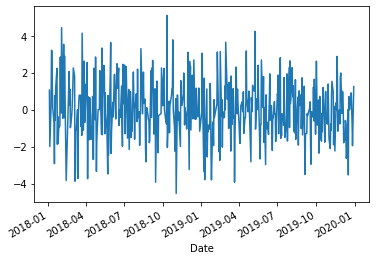

In [ ]:
df_ss['var_ratio'].plot()
plt.show()

일간변동률 누적합

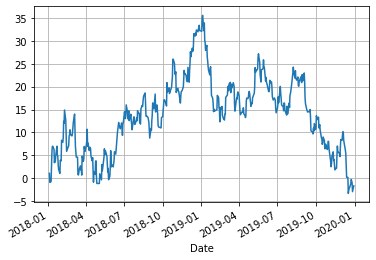

In [ ]:
df_ss['var_ratio'].cumsum().plot()
plt.grid()
plt.show()

# 수익률 계산하기

<img src="https://lh3.googleusercontent.com/proxy/gRuP6Dv7YkP3PMW38vTdNi3OwYqTfd5v2vtyseU4FQP2Qvyt-6wLx-bCEWclWTIgbu9xnFoIN4vTS9RxAVOyQ4-sLhSujArylgspLzmEbngeaCLc6ZYM6bVazfZbXyvWy04bOPIyYA9xE-6SM-wevg5qv1pr53xYPoSvgr07JK4nZHx6kWE1vek03tKhakafY344sXpTtDJqz_t4iDZC">

* HPR : 기간수익률

* 단순 이동평균선- 산술평균 기반
* 연간보유수익률 - 기하평균 기반


## 단순 이동평균선 구하기
* N일의 주가지수의 이동 평균 변동률
* 이동평균선(N일 동안의 주가의 평균 변동률을 이은 선)

In [ ]:
def simple_moving_average(col , day= 1):
  SMA = df_ss[col].rolling(window = day).mean()
  return SMA

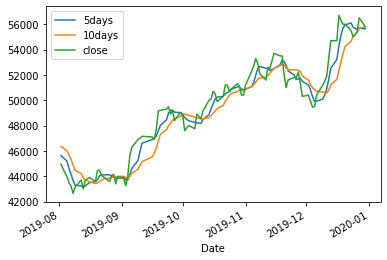

In [ ]:
simple_moving_average('Close', 5)[-100:].plot(label='5days')
simple_moving_average('Close',10)[-100:].plot(label = '10days')
df_ss['Close'][-100:].plot(label= 'close')
plt.legend()
plt.show()

 이동평균선은 변동성이 원화된 것처럼 보인다. 

#### 수익률의 이동평균선 구하기 
- 변동률 이용

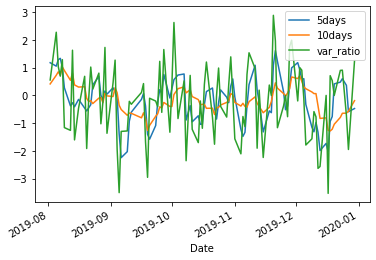

In [ ]:
windowsize =5
simple_moving_average('var_ratio',3 )[-100:].plot(label='5days')
simple_moving_average('var_ratio',10)[-100:].plot(label = '10days')
df_ss['var_ratio'][-100:].plot(label= 'var_ratio')
plt.legend()
plt.show()

#### 변동가의 이동평균선 구하기 

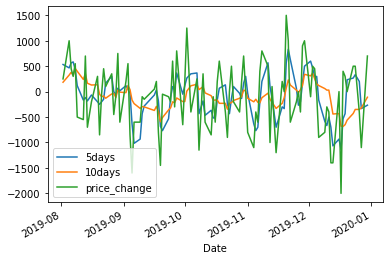

In [ ]:
windowsize =5
simple_moving_average('price_change',3 )[-100:].plot(label='5days')
simple_moving_average('price_change',10)[-100:].plot(label = '10days')
df_ss['price_change'][-100:].plot(label= 'price_change')
plt.legend()
plt.show()

### 연간보유수익률 계산하기
- 보유기간수익률의 기하평균

In [ ]:
df_ss.index[:243]

DatetimeIndex(['2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-15', '2018-01-16',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2019-01-02'],
              dtype='datetime64[ns]', name='Date', length=243, freq=None)

In [ ]:
df_ss['HPR']= df_ss['Close'].pct_change(periods= -243).shift(243)

In [ ]:
#연간보유기간수익률(기하평균)
from functools import reduce
def geometric_mean(arr):
    multiply = reduce(lambda x, y: x * y, arr) #배열 원소의 전체곱을 return
    geometric_mean = multiply**(1/len(arr))-1
    return geometric_mean

geometric_mean(np.array(df_ss['HPR'][243:]+1)) 

## Neural Network로 모델 예측하기
* 계산한 수익률은 투자전략을 세우기 위해 사용
* 추가 지표 없이 NN학습 우선 시도

In [ ]:
df = pd.concat([df_ss,simple_moving_average('Close', 5)],axis=1)
df.rename(columns = {'Close':"5days"},inplace= True)

In [ ]:
from sklearn.preprocessing import StandardScaler
y = df_ss['Close']
X= df_ss.drop('Close', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test= train_test_split(X_scaled,y, test_size=0.3)


In [ ]:
from keras import Sequential, Dense

## 부록: 수익률 관련 용어들

### 기대수익률

In [ ]:
return_rate = [0.2,0.08,-0.04] #수익률
state = ['boom','normal','depression'] #호황 보통 불황
possibility = [0.3,0.4,0.3] #각 경제상태가 도래할 가능성

eco_df = pd.DataFrame({'return_rate':return_rate, 'possibility':possibility},index = state)
eco_df

,return_rate,possibility
boom,0.20,0.3
normal,0.08,0.4
depression,-0.04,0.3


In [ ]:
기대수익률 = (eco_df['return_rate']*eco_df['possibility']).sum()
기대수익률

0.08

### 변동계수(Coefficient of Variation)
변동계수 = 자산수익률의 표준편차/ 자산기대수익률

In [ ]:
np.std(return_rate)/기대수익률

1.2247448713915892

### 가중평균수익률

In [ ]:
securities = ['fund','bond','real estate']
asset = [4000,4000,2000]
after= [5000,4200,2200]

portfolio_df = pd.DataFrame({'asset':asset,'after':after}, index= securities)

In [ ]:
portfolio_df

,asset,after
fund,4000,5000
bond,4000,4200
real estate,2000,2200


In [ ]:
portfolio_df['annual_return'] = (portfolio_df['after']-portfolio_df['asset'])/portfolio_df['asset']
portfolio_df['ratio'] = portfolio_df['asset']/portfolio_df['asset'].sum()
portfolio_df['weight']= portfolio_df['annual_return']*portfolio_df['ratio']

In [ ]:
portfolio_df

,asset,after,annual_return,ratio,weight
fund,4000,5000,0.25,0.4,0.10
bond,4000,4200,0.05,0.4,0.02
real estate,2000,2200,0.10,0.2,0.02


In [ ]:
가중평균수익률 = portfolio_df['weight'].sum()
가중평균수익률

0.14

In [ ]:
#np.dot으로 구하기 
ratio = portfolio_df['ratio']
annual_return= portfolio_df['annual_return']

#가중평균수익률
np.dot(np.array(ratio), np.array(annual_return).reshape(-1,1))

array([0.14])